## Kirchhoff migration

In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.lsm       import LSM
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

from pylops.optimization.basic import cgls as pylops_cgls
from pylops.optimization.basic import lsqr as pylops_lsqr

# Params
dynamic = False
cp = cp
dtype = np.float32

if cp == np:
    cp_asnumpy = cp.asarray
else:
    cp_asnumpy = cp.asnumpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


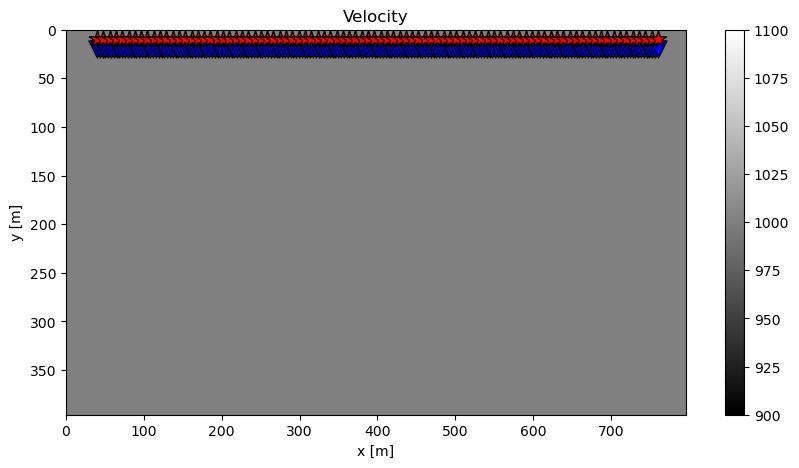

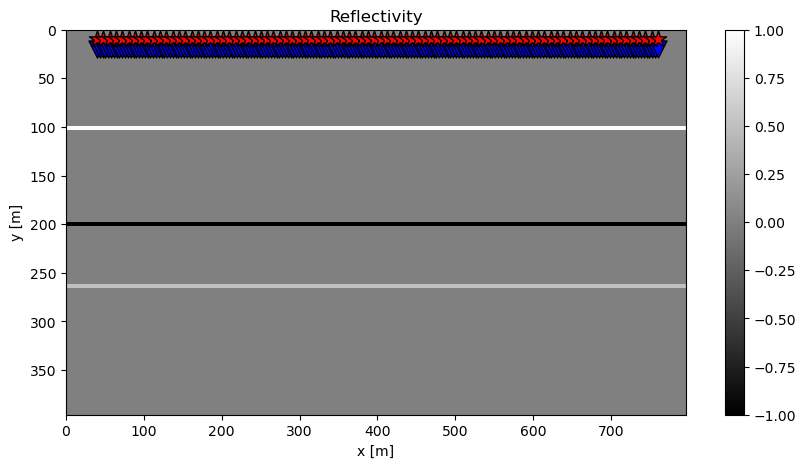

In [54]:
# Velocity Model
nx, nz = 200, 100 # 800, 300
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz), dtype=dtype)
refl[:, nz//4] = 1
refl[:, nz//2] = -1
refl[:, 2*nz//3] = 0.5

# Receivers
nr = 201 # 401
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20 * np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 90 # 101
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10 * np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

# Wavelet
nt = 1001
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

## Numba: multi core

In [55]:
lsmnp = LSM(z, x, t, sources, recs, v0, wav.astype(dtype), wavc, mode='analytic',
            engine='numba', dynamic=dynamic, dtype=dtype)
lsmnp.Demop.trav_srcs = lsmnp.Demop.trav_srcs.astype(dtype)
lsmnp.Demop.trav_recs = lsmnp.Demop.trav_recs.astype(dtype)
# dottest(lsmnp.Demop, atol=1e-3, verb=True);

Forward / Adjoint

In [56]:
dnp = lsmnp.Demop.matvec(refl.ravel())
dnp = dnp.reshape(ns, nr, nt)

madjnp = lsmnp.Demop.rmatvec(dnp.ravel())
madjnp = madjnp.reshape(nx, nz)

dnp.dtype, madjnp.dtype

(dtype('float32'), dtype('float32'))

Inversion

In [57]:
minvnp = lsmnp.solve(dnp.ravel(), solver=pylops_lsqr, **dict(x0=np.zeros_like(refl, dtype=dtype).ravel(), niter=10, show=True))
minvnp = minvnp.reshape(nx, nz)

dinvnp = lsmnp.Demop * minvnp.ravel()
dinvnp = dinvnp.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 18108090 rows and 20000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  1.175e+04  1.175e+04   1.0e+00  1.9e-01
     1  1.3610e-03  9.264e+03  9.264e+03   7.9e-01  7.1e-01  3.7e+03  1.0e+00
     2  3.2692e-03  7.349e+03  7.349e+03   6.3e-01  3.9e-01  5.6e+03  2.6e+00
     3  5.6259e-03  5.340e+03  5.340e+03   4.5e-01  2.0e-01  6.3e+03  4.6e+00
     4  3.2038e-03  4.098e+03  4.098e+03   3.5e-01  1.4e-01  6.6e+03  6.9e+00
     5 -2.3014e-03  3.184e+03  3.184e+03   2.7e-01  9.9e-02  6.8e+03  9.4e+00
     6 -3.8660e-03  2.593e+03  2.593e+03   2.2e-01  7.8e-02  7.0e+03  1.2e+01
     7 -3.

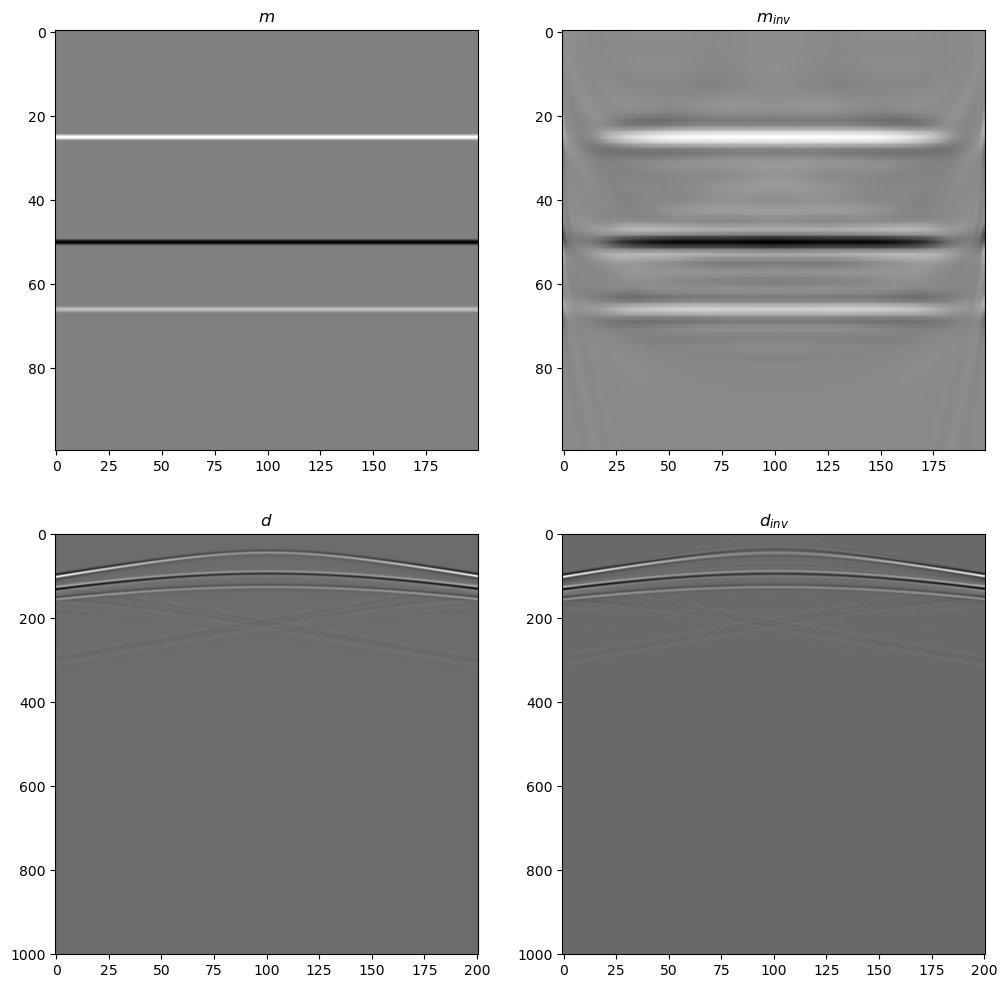

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(minvnp.T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(dnp[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(dinvnp[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');

## Numba Cuda

In [59]:
lsmcp = LSM(z, x, t, sources, recs, v0, cp.asarray(wav).astype(dtype), wavc, 
            mode='analytic', engine='cuda', dynamic=dynamic, dtype=dtype)

# directly lift traveltimes to gpu since we want to perform all operations of the GPU
lsmcp.Demop.trav_srcs = cp.asarray(lsmcp.Demop.trav_srcs)
lsmcp.Demop.trav_recs = cp.asarray(lsmcp.Demop.trav_recs)

print('Number of threads and blocks:', lsmcp.Demop.cuda_helper.num_threads_per_blocks, lsmcp.Demop.cuda_helper.num_blocks)
# dottest(lsmcp.Demop, verb=True, backend='cupy', atol=1e-1, raiseerror=False);

Number of threads and blocks: (32, 32) (3, 7)


Forward / Adjoint

In [60]:
reflcp = cp.asarray(refl)
dcp = lsmcp.Demop * reflcp.ravel()
dcp = dcp.reshape(ns, nr, nt)

madjcp = lsmcp.Demop.H * dcp.ravel()
madjcp = madjcp.reshape(nx, nz)

type(dcp), type(madjcp), dcp.dtype, madjcp.dtype

(cupy.ndarray, cupy.ndarray, dtype('float32'), dtype('float32'))

Inverse

In [61]:
minvcp = lsmcp.solve(dcp.ravel(), solver=pylops_lsqr, **dict(x0=cp.zeros_like(refl, dtype=dtype).ravel(), niter=10, show=True))
minvcp = minvcp.reshape(nx, nz)

dinvcp = lsmcp.Demop * minvcp.ravel()
dinvcp = dinvcp.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 18108090 rows and 20000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  1.175e+04  1.175e+04   1.0e+00  1.9e-01
     1  1.3610e-03  9.264e+03  9.264e+03   7.9e-01  7.1e-01  3.7e+03  1.0e+00
     2  3.2692e-03  7.350e+03  7.350e+03   6.3e-01  3.9e-01  5.6e+03  2.6e+00
     3  5.6260e-03  5.340e+03  5.340e+03   4.5e-01  2.0e-01  6.3e+03  4.6e+00
     4  3.2037e-03  4.099e+03  4.099e+03   3.5e-01  1.4e-01  6.6e+03  6.9e+00
     5 -2.3024e-03  3.185e+03  3.185e+03   2.7e-01  9.9e-02  6.8e+03  9.4e+00
     6 -3.8877e-03  2.584e+03  2.584e+03   2.2e-01  6.6e-02  7.0e+03  1.2e+01
     7 -3.

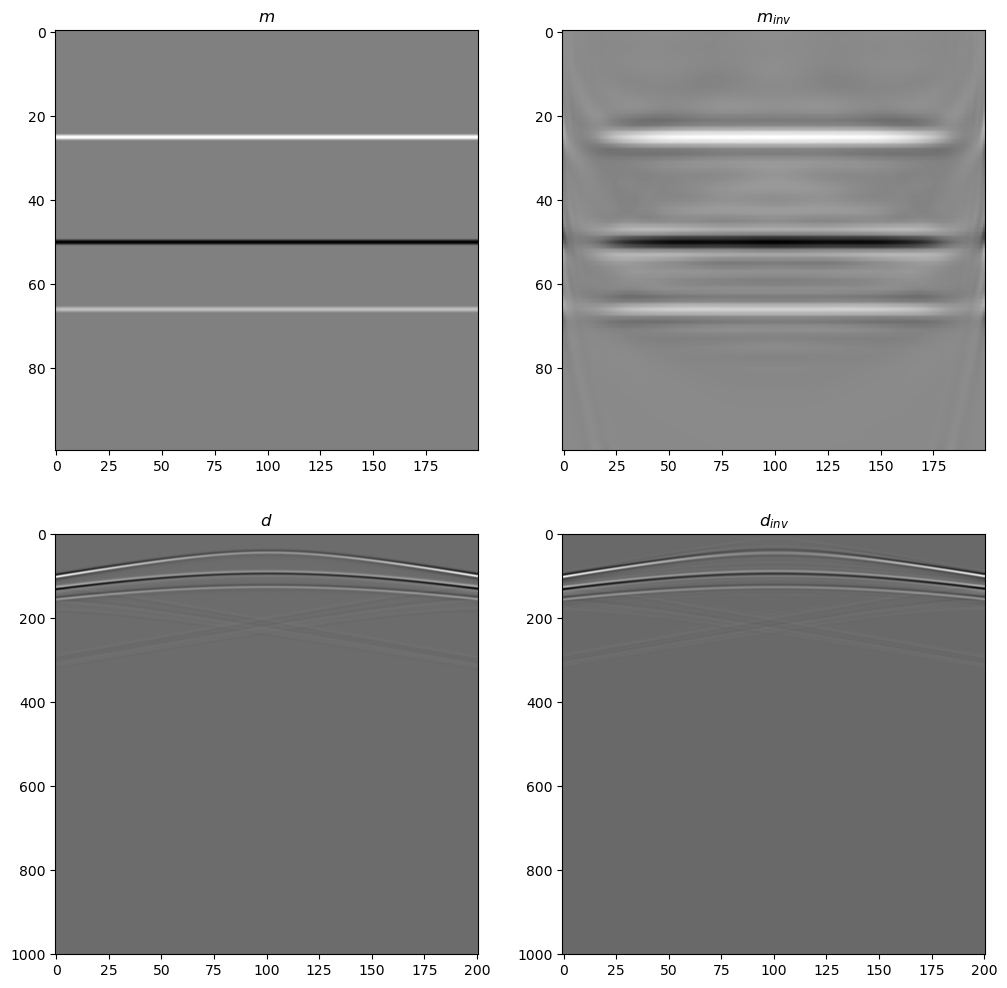

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(cp_asnumpy(minvcp).T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(cp_asnumpy(dcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(cp_asnumpy(dinvcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');

## Comparison CPU vs GPU

(True, True)

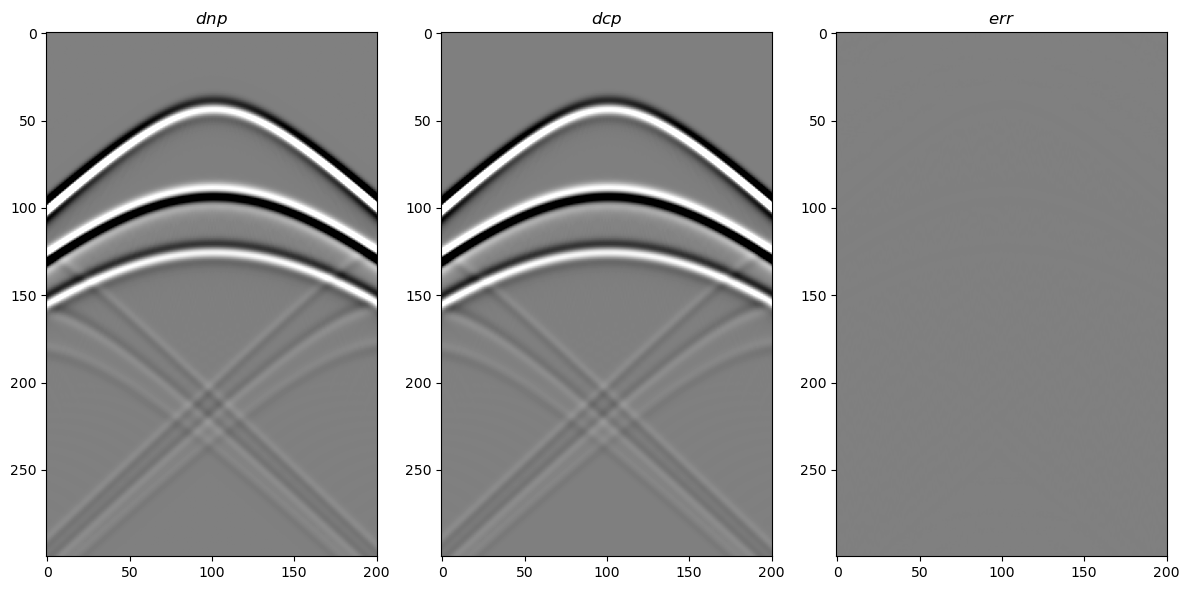

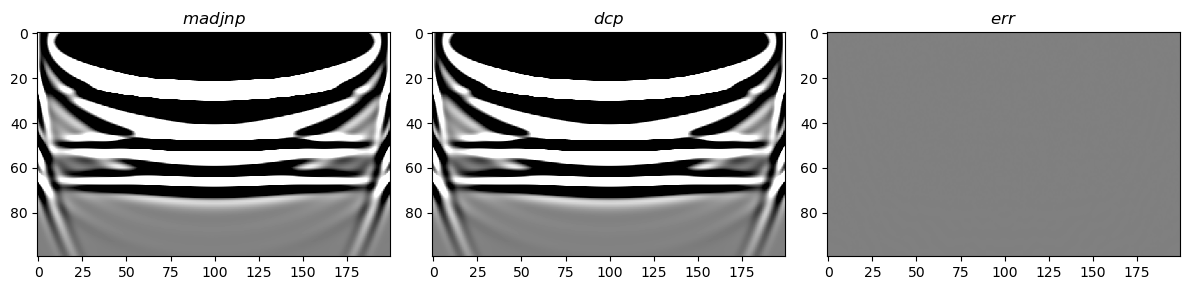

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  

axs[0].imshow(dnp[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)  
axs[0].set_title(r'$dnp$')
axs[0].axis('tight')

axs[1].imshow(cp_asnumpy(dcp)[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)   
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(dnp[ns//2, :, :300].T - cp_asnumpy(dcp)[ns//2, :, :300].T, 
              cmap='gray', vmin=-1e1, vmax=1e1)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))  

axs[0].imshow(madjnp.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[0].set_title(r'$madjnp$')
axs[0].axis('tight')

axs[1].imshow(cp_asnumpy(madjcp).T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(madjnp.T - cp_asnumpy(madjcp).T, 
              cmap='gray', vmin=-1e4, vmax=1e4)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

np.allclose(dnp, cp_asnumpy(dcp), rtol=1e-2, atol=1e-2), np.allclose(madjnp, cp_asnumpy(madjcp), rtol=1e-1, atol=1e-1)

In [64]:
%timeit -n 2 -r 2 lsmnp.Demop.matvec(refl.ravel())
%timeit -n 2 -r 2 lsmnp.Demop.rmatvec(dnp.ravel())

513 ms ± 711 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
527 ms ± 51.3 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [65]:
%timeit -n 2 -r 2 lsmcp.Demop.matvec(reflcp.ravel())
%timeit -n 2 -r 2 lsmcp.Demop.rmatvec(dcp.ravel())

116 ms ± 4.07 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
114 ms ± 157 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


## Numba Cuda with ToCupy

Here we test the Kirchhoff when the input and output are forced to cupy and back to numpy using the `ToCupy` operator.

In [66]:
Kop = Kirchhoff(z, x, t, sources, recs, v0, 
                wav.astype(dtype), 
                wavc, mode='analytic', 
                engine='cuda', dynamic=dynamic, 
                dtype=dtype)
Top = ToCupy(Kop.dims)
Top1 = ToCupy(Kop.dimsd)
Kop = Top1.H @ Kop @ Top

In [67]:
dcp1 = Kop * refl.ravel()
dcp1 = dcp1.reshape(ns, nr, nt)

madjcp1 = Kop.H * dcp1.ravel()
madjcp1 = madjcp1.reshape(nx, nz)

type(dcp1), type(madjcp1), dcp1.dtype, madjcp1.dtype

(numpy.ndarray, numpy.ndarray, dtype('float32'), dtype('float32'))

## Numba Cuda with VStack over groups of sources

This is useful when the size of the problem does not allow lifting all of the required variables onto the GPU upfront. Still each operator will lift part of the information for a restricted number of sources on-demand.

In [68]:
nsrop = 30 # number of source for each single operator
Kops = []
for isrc in range(0, ns, nsrop):
    print(f'Creating operator for sources {isrc}-{min(isrc + nsrop, ns)}/{ns}')
    Kop = Kirchhoff(z, x, t, sources[:, isrc:min(isrc + nsrop, ns)], recs, v0, 
                    cp.asarray(wav.astype(dtype)), 
                    wavc, mode='analytic', 
                    engine='cuda', dynamic=dynamic, 
                    dtype=dtype)
    Top = ToCupy(Kop.dims, dtype=dtype)
    Top1 = ToCupy(Kop.dimsd, dtype=dtype)
    Kop = Top1.H @ Kop @ Top
    Kops.append(Kop)
Kops = VStack(Kops)

Creating operator for sources 0-30/90
Creating operator for sources 30-60/90
Creating operator for sources 60-90/90


In [69]:
dcp2 = Kops * refl.ravel()
dcp2 = dcp2.reshape(ns, nr, nt)

madjcp2 = Kops.H * dcp2.ravel()
madjcp2 = madjcp2.reshape(nx, nz)

type(dcp2), type(madjcp2), dcp2.dtype, madjcp2.dtype

(numpy.ndarray, numpy.ndarray, dtype('float32'), dtype('float32'))

(True, True)

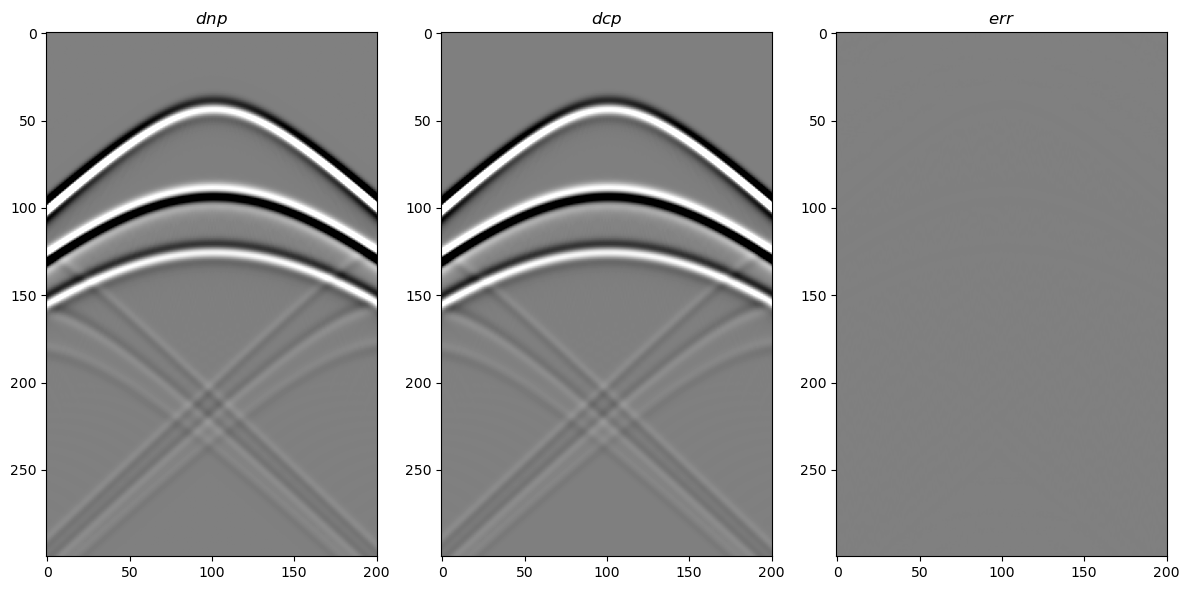

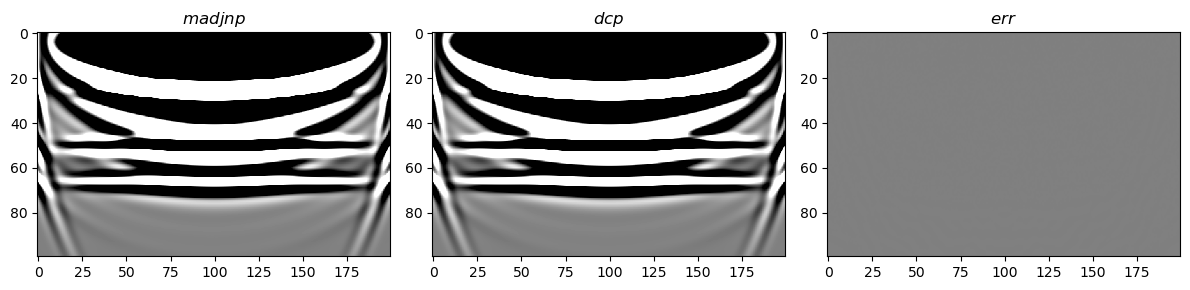

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  
axs[0].imshow(dnp[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)  
axs[0].set_title(r'$dnp$')
axs[0].axis('tight')

axs[1].imshow(dcp2[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)   
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(dnp[ns//2, :, :300].T - dcp2[ns//2, :, :300].T, 
              cmap='gray', vmin=-1e1, vmax=1e1)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))  
axs[0].imshow(madjnp.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[0].set_title(r'$madjnp$')
axs[0].axis('tight')

axs[1].imshow(madjcp2.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(madjnp.T - madjcp2.T, 
              cmap='gray', vmin=-1e4, vmax=1e4)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

np.allclose(dnp, dcp2, rtol=1e-2, atol=1e-2), np.allclose(madjnp, madjcp2, rtol=1e-1, atol=1e-1)

In [71]:
%timeit -n 2 -r 2 Kops.matvec(refl.ravel())
%timeit -n 2 -r 2 Kops.rmatvec(dcp2.ravel())

430 ms ± 188 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
384 ms ± 3.99 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [72]:
# Inversion
minvcp2 = pylops_lsqr(Kops, dcp2.ravel(), x0=np.zeros_like(refl).ravel(), niter=10, show=True)[0]
minvcp2 = minvcp2.reshape(nx, nz)

dinvcp2 = Kops * minvcp2.ravel()
dinvcp2 = dinvcp2.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 18108090 rows and 20000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  1.175e+04  1.175e+04   1.0e+00  1.9e-01
     1  1.3610e-03  9.264e+03  9.264e+03   7.9e-01  7.1e-01  3.7e+03  1.0e+00
     2  3.2692e-03  7.349e+03  7.349e+03   6.3e-01  3.9e-01  5.6e+03  2.6e+00
     3  5.6259e-03  5.340e+03  5.340e+03   4.5e-01  2.0e-01  6.3e+03  4.6e+00
     4  3.2038e-03  4.098e+03  4.098e+03   3.5e-01  1.4e-01  6.6e+03  6.9e+00
     5 -2.3014e-03  3.184e+03  3.184e+03   2.7e-01  9.9e-02  6.8e+03  9.4e+00
     6 -3.8659e-03  2.593e+03  2.593e+03   2.2e-01  7.8e-02  7.0e+03  1.2e+01
     7 -3.

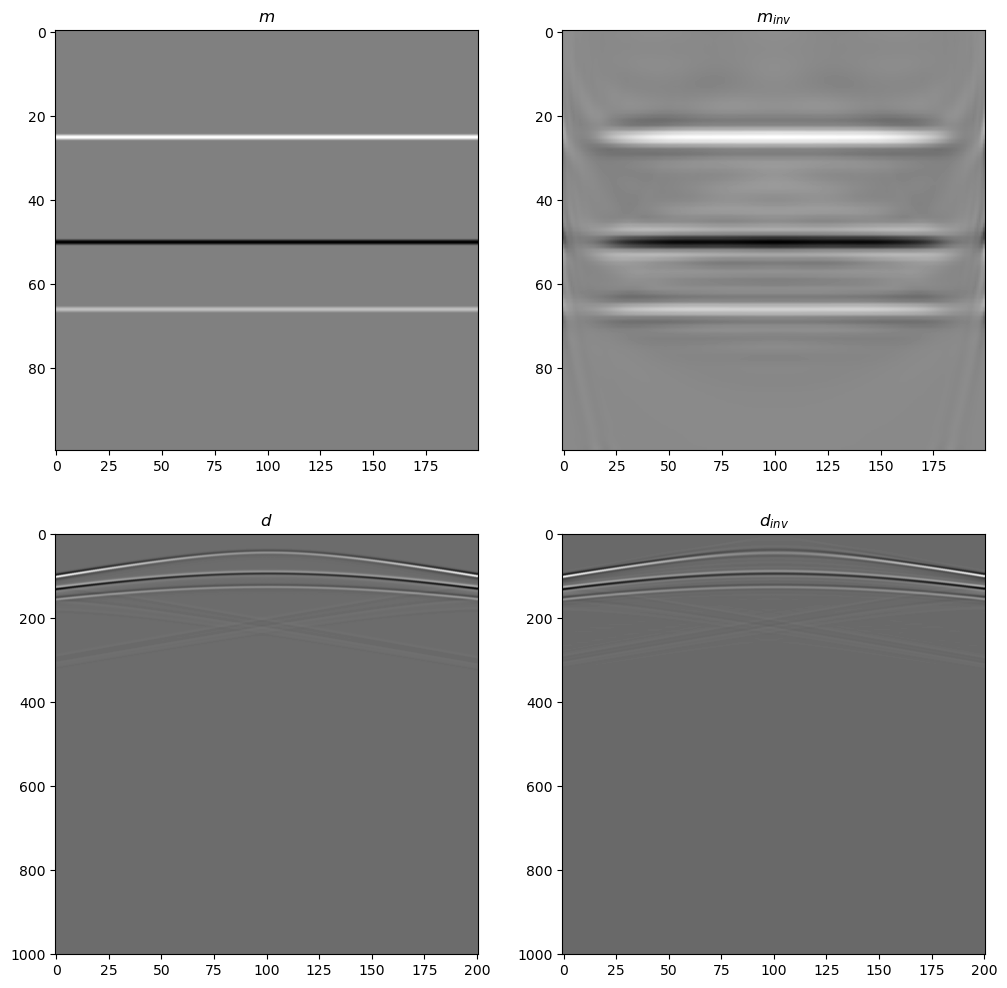

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(minvcp2.T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(cp_asnumpy(dcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(dinvcp2[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');

## Numba Cuda with VStack over groups of sources (keeping model on GPU)

In [74]:
nsrop = 30 # number of source for each single operator
Kops = []
for isrc in range(0, ns, nsrop):
    print(f'Creating operator for sources {isrc}-{min(isrc + nsrop, ns)}/{ns}')
    Kop = Kirchhoff(z, x, t, sources[:, isrc:min(isrc + nsrop, ns)], recs, v0, 
                    cp.asarray(wav.astype(dtype)), 
                    wavc, mode='analytic', 
                    engine='cuda', dynamic=dynamic, 
                    dtype=dtype)
    Top1 = ToCupy(Kop.dimsd, dtype=dtype)
    Kop = Top1.H @ Kop
    Kops.append(Kop)
Kops = VStack(Kops, inoutengine=("numpy", "cupy"))

Creating operator for sources 0-30/90
Creating operator for sources 30-60/90


Creating operator for sources 60-90/90


In [75]:
dcp2 = Kops * reflcp.ravel()
dcp2 = dcp2.reshape(ns, nr, nt)

madjcp2 = Kops.H * dcp2.ravel()
madjcp2 = madjcp2.reshape(nx, nz)

type(dcp2), type(madjcp2), dcp2.dtype, madjcp2.dtype

(numpy.ndarray, cupy.ndarray, dtype('float32'), dtype('float32'))

(True, array(True))

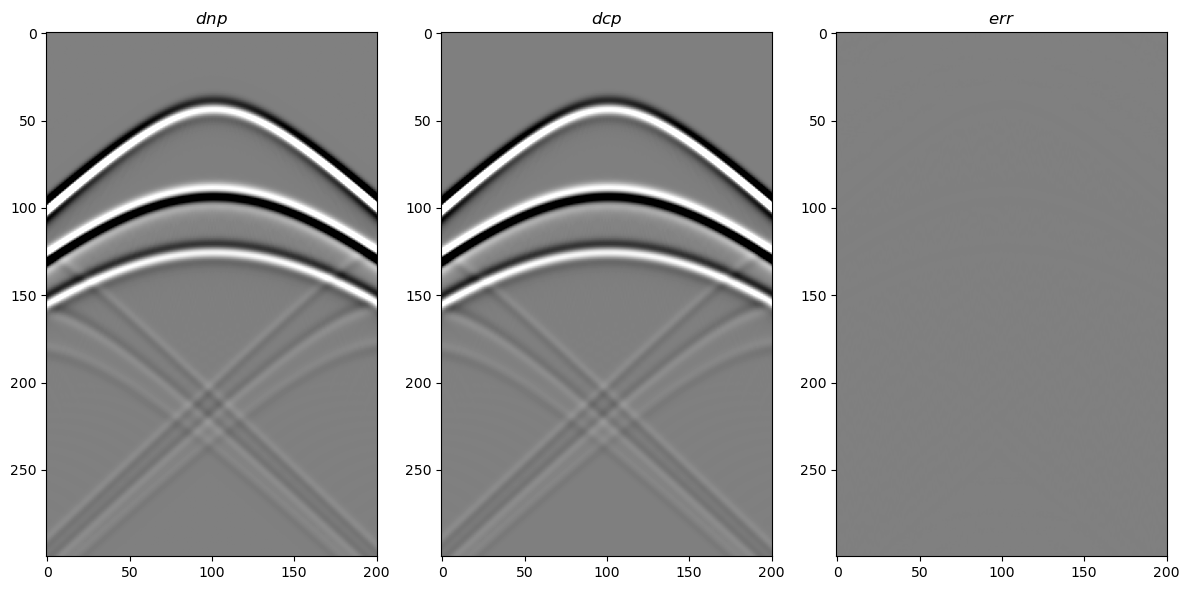

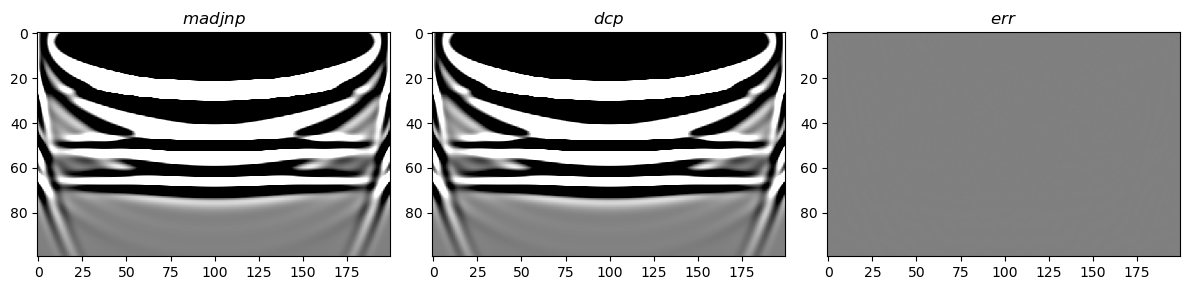

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  
axs[0].imshow(dnp[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)  
axs[0].set_title(r'$dnp$')
axs[0].axis('tight')

axs[1].imshow(dcp2[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)   
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(dnp[ns//2, :, :300].T - dcp2[ns//2, :, :300].T, 
              cmap='gray', vmin=-1e1, vmax=1e1)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))  
axs[0].imshow(madjnp.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[0].set_title(r'$madjnp$')
axs[0].axis('tight')

axs[1].imshow(cp_asnumpy(madjcp2).T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(madjnp.T - cp_asnumpy(madjcp2).T, 
              cmap='gray', vmin=-1e4, vmax=1e4)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

np.allclose(dnp, dcp2, rtol=1e-2, atol=1e-2), np.allclose(madjnp, madjcp2, rtol=1e-1, atol=1e-1)

In [77]:
# Inversion
minvcp2 = pylops_lsqr(Kops, dcp2.ravel(), x0=cp.zeros_like(refl).ravel(), niter=10, show=True)[0]
minvcp2 = minvcp2.reshape(nx, nz)

dinvcp2 = Kops * minvcp2.ravel()
dinvcp2 = dinvcp2.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 18108090 rows and 20000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  1.175e+04  1.175e+04   1.0e+00  1.9e-01
     1  1.3610e-03  9.264e+03  9.264e+03   7.9e-01  7.1e-01  3.7e+03  1.0e+00
     2  3.2692e-03  7.349e+03  7.349e+03   6.3e-01  3.9e-01  5.6e+03  2.6e+00
     3  5.6259e-03  5.340e+03  5.340e+03   4.5e-01  2.0e-01  6.3e+03  4.6e+00
     4  3.2038e-03  4.098e+03  4.098e+03   3.5e-01  1.4e-01  6.6e+03  6.9e+00
     5 -2.3014e-03  3.184e+03  3.184e+03   2.7e-01  9.9e-02  6.8e+03  9.4e+00
     6 -3.8656e-03  2.593e+03  2.593e+03   2.2e-01  7.8e-02  7.0e+03  1.2e+01
     7 -3.

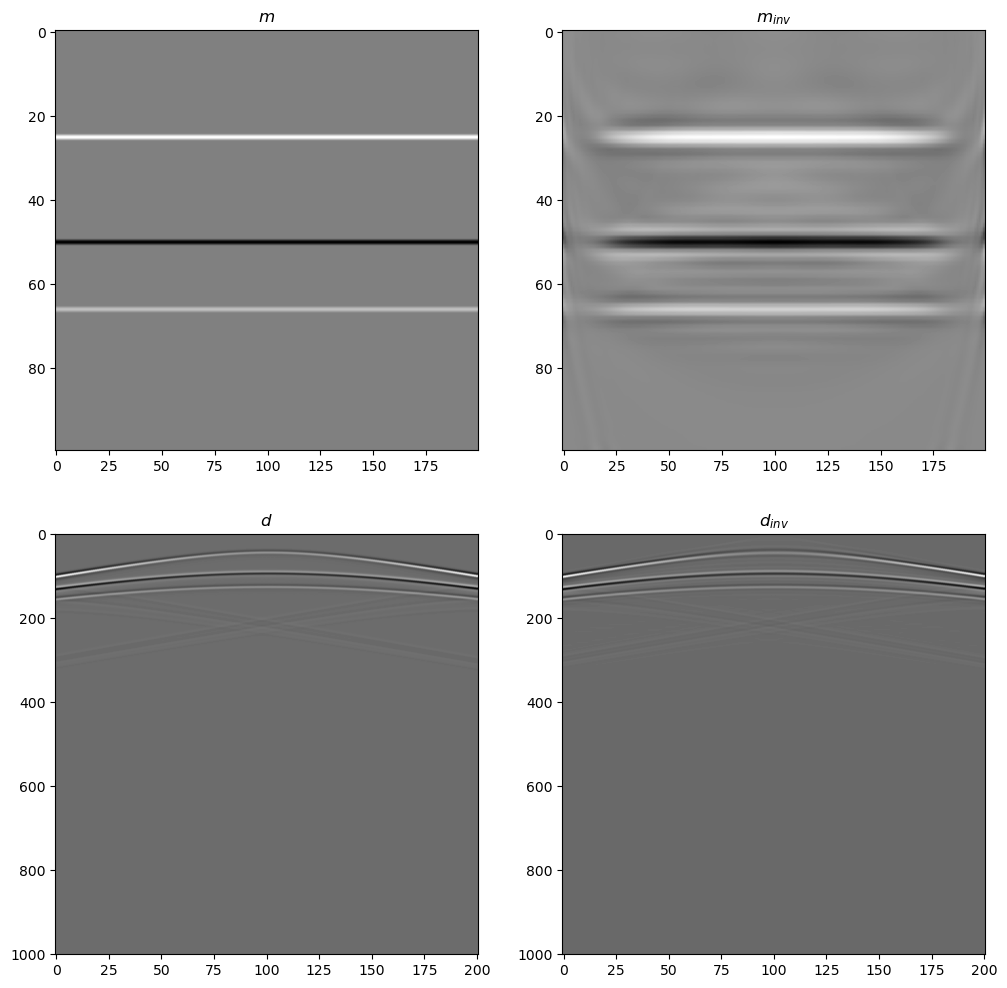

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(cp_asnumpy(minvcp2).T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(cp_asnumpy(dcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(dinvcp2[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');